In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings(action='ignore')

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from deepctr.models import DeepFM
from deepctr.feature_column import SparseFeat, DenseFeat, get_feature_names
from sklearn.metrics import roc_auc_score

from tensorflow.keras.callbacks import EarlyStopping

In [6]:
df = pd.read_csv("./datasets/dataset.csv", index_col=0)
print(df.shape)

(100000, 30)


In [7]:
df = df.drop("시험구분", axis=1).dropna()
print(df.shape)

(90426, 29)


In [8]:
df['정오답'] = df['정오답'].map({'O': 1, 'X': 0})

In [9]:
data = df[['사용자ID','단원제목','학년','학기','동영상재생시간','실제재생시간','문항코드','대단원제목','중단원제목','소단원제목','난이도', '정오답']]

In [10]:
data.columns = ['Col_1','Col_2','Col_3','Col_4','Col_5','Col_6',\
                'Col_7','Col_8','Col_9','Col_10','Col_11','Col_12']

data.columns

Index(['Col_1', 'Col_2', 'Col_3', 'Col_4', 'Col_5', 'Col_6', 'Col_7', 'Col_8',
       'Col_9', 'Col_10', 'Col_11', 'Col_12'],
      dtype='object')

In [11]:
# Data 구분 by columns
sparse_features = ['Col_1','Col_2','Col_8','Col_9','Col_10']
dense_features = ['Col_3','Col_4','Col_5','Col_6','Col_7','Col_11']
target = ['Col_12']

# Sparse & Dense 데이터에 대해 각 encoding과 labeling 진행
for feat in sparse_features:
    encoder = LabelEncoder()
    data[feat] = encoder.fit_transform(data[feat])

scaler = MinMaxScaler(feature_range=(0, 1))
data[dense_features] = scaler.fit_transform(data[dense_features])

fixlen_feature_columns = [SparseFeat(feat, vocabulary_size=data[feat].max() + 1, embedding_dim=4)
                              for i, feat in enumerate(sparse_features)] + [DenseFeat(feat, 1, )
                                                                            for feat in dense_features]

                           
dnn_feature_columns = fixlen_feature_columns
linear_feature_columns = fixlen_feature_columns

feature_names = get_feature_names(linear_feature_columns + dnn_feature_columns)

In [12]:
train_set, test_set = train_test_split(data, test_size=0.2, random_state=42)
train_model_input = {name: train_set[name] for name in feature_names}
test_model_input = {name: test_set[name] for name in feature_names}

y_train = train_set[target]
y_test = test_set[target]

In [16]:
# DeepFM 
class DeepFMModel:
    def __init__(self, linear_feature_columns, dnn_feature_columns, task='binary', optimizer='adam', loss='binary_crossentropy', metrics_list=['acc']):
        self.linear_feature_columns = linear_feature_columns
        self.dnn_feature_columns = dnn_feature_columns
        self.task = task
        self.optimizer = optimizer
        self.loss = loss
        self.metrics = metrics_list
        self.model = None
        
    def _build(self):
        model = DeepFM(self.linear_feature_columns, self.dnn_feature_columns, task=self.task)
        model.compile(optimizer=self.optimizer,
                      loss = self.loss,
                      metrics=self.metrics)
        return model
    
    def train(self, input_data, target_data, epochs):
        self.model = self._build()
        es = EarlyStopping(monitor='val_loss', patience=5, verbose=2, mode='auto')
        hist = self.model.fit(input_data, 
                              target_data, 
                              epochs=epochs,
                              callbacks=[es],
                              validation_split=0.2)
        return hist
    
    def predict(self, data):
        return self.model.predict(data)
    
    def evaluate(self, train_input, train_target):
        predict = self.predict(train_input)
        print("R2 score: ", round(r2_score(predict, train_target), 4))
        
    def _save(self, path):
        self.model.save(path)

In [17]:
epochs = 100

model = DeepFMModel(
    linear_feature_columns=linear_feature_columns, 
    dnn_feature_columns=dnn_feature_columns
    )

history = model.train(train_model_input, y_train, epochs=epochs)
y_pred = model.predict(test_model_input)

Train on 57872 samples, validate on 14468 samples
Epoch 1/100
57872/57872 [==============================] - 14s 244us/sample - loss: 0.5101 - acc: 0.7550 - val_loss: 0.5030 - val_acc: 0.7600
Epoch 2/100
57872/57872 [==============================] - 16s 278us/sample - loss: 0.4949 - acc: 0.7653 - val_loss: 0.4919 - val_acc: 0.7649
Epoch 3/100
57872/57872 [==============================] - 14s 238us/sample - loss: 0.4819 - acc: 0.7750 - val_loss: 0.4810 - val_acc: 0.7741
Epoch 4/100
57872/57872 [==============================] - 14s 245us/sample - loss: 0.4723 - acc: 0.7796 - val_loss: 0.4776 - val_acc: 0.7760
Epoch 5/100
57872/57872 [==============================] - 12s 210us/sample - loss: 0.4628 - acc: 0.7847 - val_loss: 0.4657 - val_acc: 0.7794
Epoch 6/100
57872/57872 [==============================] - 11s 196us/sample - loss: 0.4548 - acc: 0.7894 - val_loss: 0.4648 - val_acc: 0.7807
Epoch 7/100
57872/57872 [==============================] - 12s 199us/sample - loss: 0.4466 - acc: 

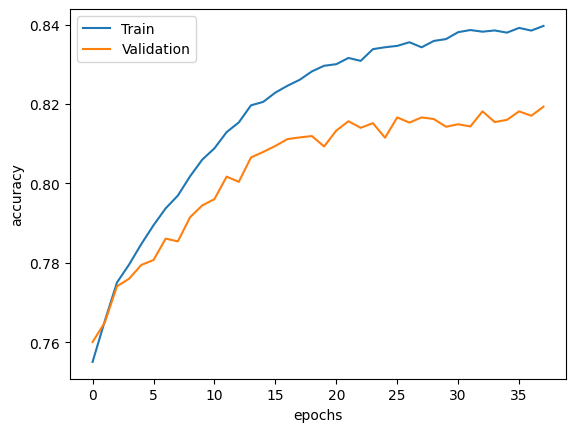

In [21]:
epoch_range = range(len(history.history['acc']))

plt.plot(epoch_range, history.history['acc'])
plt.plot(epoch_range, history.history['val_acc'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['Train','Validation'])
plt.show()

In [25]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
y_pred = model.predict(test_model_input)
y_pred = pd.Series(y_pred.reshape(-1)).map(lambda x: 1 if x>0.5 else 0)
print("Accuracy score for Test set: {}".format(round(accuracy_score(y_test, y_pred=y_pred),5)))

Accuracy score for Test set: 0.81975


<AxesSubplot:>

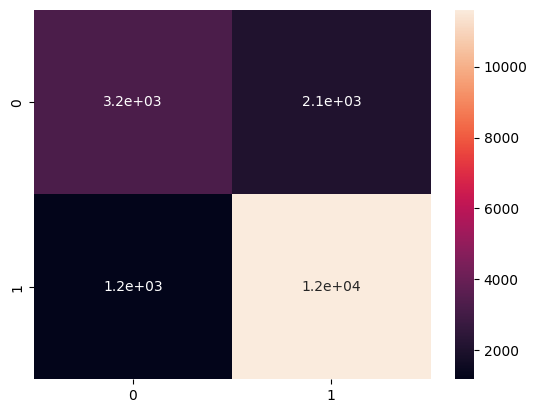

In [26]:
cm = confusion_matrix(y_pred=y_pred, y_true=y_test)
sns.heatmap(cm, annot=True)

In [27]:
print(classification_report(y_pred=y_pred, y_true=y_test))

              precision    recall  f1-score   support

           0       0.73      0.61      0.66      5296
           1       0.85      0.91      0.88     12790

    accuracy                           0.82     18086
   macro avg       0.79      0.76      0.77     18086
weighted avg       0.81      0.82      0.81     18086



In [30]:
from sklearn.metrics import roc_auc_score

print("AUC score: {}".format(round(roc_auc_score(y_pred, y_test), 4)))

AUC score: 0.7897
